In [1]:
!pip install d2l==1.0.3

In [2]:
!pip install sympy --upgrade

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
import matplotlib.patches as patches
from torchvision import tv_tensors
from torchvision.transforms import v2
from torchvision import transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
from d2l import torch as d2l
import json
import pandas as pd
import numpy as np
import os

In [30]:
#Ejemplo del laboratorio para aumentar imagenes

def augment_csv(n_augment, img_labels):
    """Repeats each row of the DataFrame n_augment times."""

    # Filter for 'region_attributes' equal to {Label:"C"}
    filtered_img_labels = img_labels[img_labels['region_attributes'] == '{"Label":"C"}']

    # Repeat each row of the filtered DataFrame n_augment times
    repeated_df = filtered_img_labels.loc[filtered_img_labels.index.repeat(n_augment)]
    repeated_df = repeated_df.reset_index(drop=True)  # Restablecer el índice


    return repeated_df

In [31]:
#Estableciendo la estructura del dataset
class ImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir,n_augment=5, split="train", transform=None, test_size=0.2, random_seed=42):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

        # Dividir aleatoriamente en entrenamiento y prueba
        np.random.seed(random_seed)
        indices = np.random.permutation(len(self.img_labels))
        split_index = int(len(self.img_labels) * (1 - test_size))

        if split == "train":
            self.img_labels = self.img_labels.iloc[indices[:split_index]]
        else:
            self.img_labels = self.img_labels.iloc[indices[split_index:]]

        self.img_labels = augment_csv(n_augment,  self.img_labels)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
         img_filename = self.img_labels.iloc[idx]['filename']
         img_path = os.path.join(self.img_dir, img_filename)
         image = read_image(img_path).float() / 255.0  # Normalizamos a [0, 1]

        # Lee los atributos de la bounding box
         shape_attributes = json.loads(self.img_labels.iloc[idx]['region_shape_attributes'])
         label = self.img_labels.iloc[idx]['region_attributes']

        # Extrae los extremos superior izq y el inferior der.
         x_1 = shape_attributes['x'] # Coordenada x del extremo superior izquierdo
         y_1 = shape_attributes['y']  # Coordenada y del extremo superior izquierdo
         x_2 =  shape_attributes['x'] + shape_attributes['width']
         y_2 = shape_attributes['y'] + shape_attributes['height']

         bbox = torch.tensor([x_1, y_1, x_2, y_2])
         bb_box = tv_tensors.BoundingBoxes(bbox.unsqueeze(0), format="XYXY", canvas_size=(image.shape[1], image.shape[2]))

        # Si hay transformaciones definidas, se aplican
         if self.transform:
            # Aplica transformaciones a imagen y bounding box
            image, bb_box = self.transform(image, bb_box)

         return image, bb_box , label

In [32]:
#"/content/drive/MyDrive/Proyecto-Integrador-Redes/Dataset/Letras_Gonza.csv" , "/content/drive/MyDrive/Proyecto-Integrador-Redes/Dataset/Letras"

transform = v2.Compose([
    v2.Resize(size=(960, 1000)),#aplicamos resize para que torch.stack no tenga problemas ya que habian imagenes que no tenian el mismo tamaño
    v2.RandomRotation(20),
    v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    v2.RandomRotation(10),
    v2.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.95, 1.05)),
])


train_dataset = ImageDataset(
    annotations_file= "/content/drive/MyDrive/Proyecto-Integrador-Redes/Dataset/Letras_Gonza.csv",
    img_dir= "/content/drive/MyDrive/Proyecto-Integrador-Redes/Dataset/Letras",
    n_augment = 10,
    split="train",
    transform=transform
)

test_dataset = ImageDataset(
    annotations_file= "/content/drive/MyDrive/Proyecto-Integrador-Redes/Dataset/Letras_Gonza.csv",
    img_dir= "/content/drive/MyDrive/Proyecto-Integrador-Redes/Dataset/Letras",
    n_augment = 10,
    split="test",
)

In [33]:
print("Train: ", len(train_dataset)," Test: ", len(test_dataset))

Train:  30  Test:  0


In [21]:
print(train_dataset[0])

(tensor([[[0.1162, 0.1162, 0.1162,  ..., 0.0000, 0.0000, 0.0000],
         [0.1162, 0.1162, 0.1162,  ..., 0.0000, 0.0000, 0.0000],
         [0.1162, 0.1162, 0.1162,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1162, 0.1162, 0.1162,  ..., 0.0000, 0.0000, 0.0000],
         [0.1162, 0.1162, 0.1162,  ..., 0.0000, 0.0000, 0.0000],
         [0.1162, 0.1162, 0.1162,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1162, 0.1162, 0.1162,  ..., 0.0000, 0.0000, 0.0000],
         [0.1162, 0.1162, 0.1162,  ..., 0.0000, 0.0000, 0.0000],
         [0.1162, 0.1162, 0.1162,  ..., 0.0000, 0.0000, 0

In [36]:
#Generamos los dataloaders

from torch.utils.data import DataLoader


train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

# DataLoader para el conjunto de prueba
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

In [37]:
data_iter = iter(train_loader)
images, bboxes,label = next(data_iter)# mostramos que el dataset devuelve las label correctamente
print("Las etiquetas son: ",label)

Las etiquetas son:  ('{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}', '{"Label":"C"}')


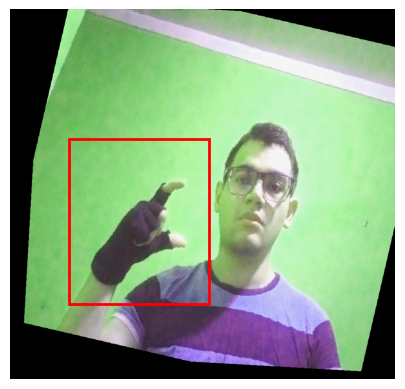

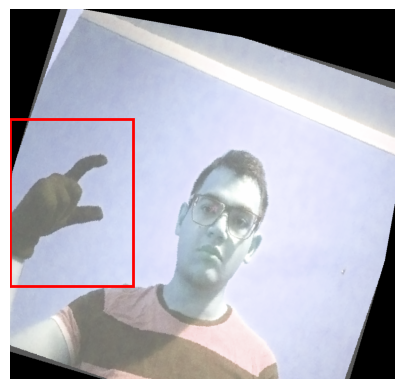

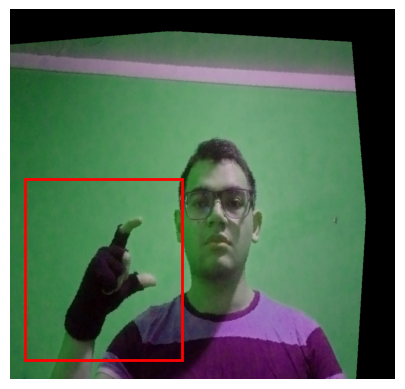

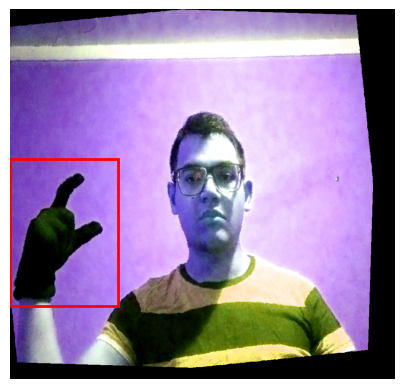

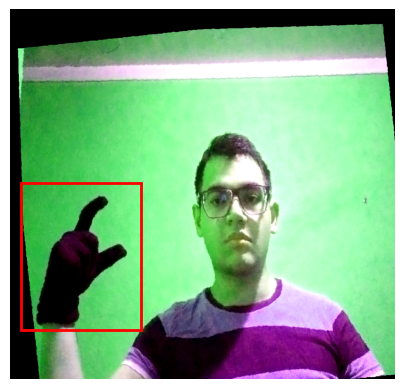

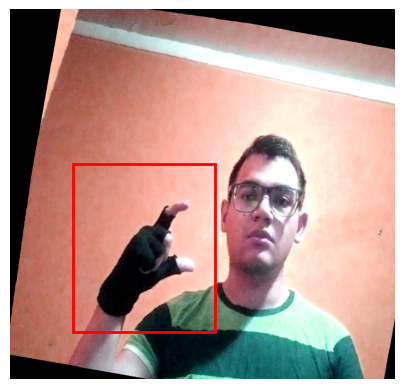

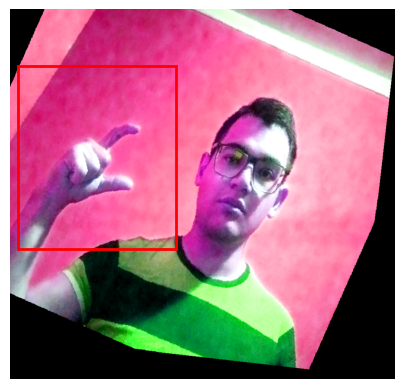

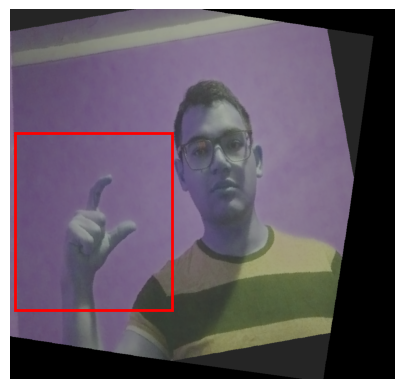

In [38]:
#Verificamos que los dataloaders esten funcionando correctamente
def plot_image_with_bbox(img, bbox, title=""):
    img_np = img.permute(1, 2, 0).numpy()  # Convertir a numpy [H, W, C]
    fig, ax = plt.subplots(1)
    ax.imshow(img_np)

    # Convertir de extremos a coordenadas de esquina superior izquierda
    x_1, y_1, x_2, y_2 = bbox.squeeze(0)
    width = x_2 - x_1
    height = y_2 - y_1

    # Crear el rectángulo con las nuevas coordenadas
    rect = patches.Rectangle((x_1, y_1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.title(title)
    plt.axis("off")
    plt.show()

# Verificar un lote de imágenes del DataLoader
data_iter = iter(train_loader)  # O puedes usar test_loader
images, bboxes,_ = next(data_iter)  # Obtener un lote

# Visualizar algunas imágenes y sus bounding boxes
for i in range(8):  # Mostrar las primeras 4 imágenes del lote
    plot_image_with_bbox(images[i], bboxes[i])


In [ ]:
# data , size = escalas de las anchor

#Genera las anchor

def multibox_prior(data, sizes, ratios):
    """Generate anchor boxes with different shapes centered on each pixel."""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    # Estos desplazamientos (offset_h, offset_w) y pasos (steps_h, steps_w)
    # se utilizan para mover el centro del anchor box al centro de cada píxel.
    # Los pasos son simplemente la inversa de la altura y el ancho para normalizar las coordenadas.
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height
    steps_w = 1.0 / in_width  # Scaled steps in x axis

    # Genera todos los puntos centrales para los anchor boxes en la imagen.
    # torch.meshgrid se utiliza para crear una cuadrícula de puntos y luego
    # se aplanan (reshape) para facilitar el cálculo posterior.
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Genera las alturas (h) y anchuras (w) para los anchor boxes
    # utilizando las escalas y relaciones de aspecto proporcionadas.
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))

    # Divide by 2 to get half height and half width
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2

    #  Cada punto central tendrá `boxes_per_pixel` número de anchor boxes, así que
# genera una cuadrícula de todos los centros de las anchor boxes con `boxes_per_pixel` repeticiones
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

In [ ]:
#Probamos que se generen correctamente las anchor
first_image = images[0]
first_bbox = bboxes[0]
first_label = label[0]


h, w = first_image.shape[-2:]
print(h, w)
X = torch.rand(size=(1, 3, h, w))  # Construct input data
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape


960 1000


torch.Size([1, 4800000, 4])

In [ ]:
boxes = Y.reshape(h, w, -1, 4)
boxes[250,250, 0, :]

In [ ]:
#Graficamos las boundding
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""

    def make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = make_list(labels)
    colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

In [ ]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(first_image.squeeze(0).permute(1, 2, 0))
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])

In [ ]:
#Caldulamos el indice de Jaccard entre las anchors y las boundding box verdaderas

def box_iou(boxes1, boxes2):
    """Calcular el IoU (Intersection over Union) entre dos listas de anchor boxes o bounding boxes."""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # Forma de `boxes1`, `boxes2`, `areas1`, `areas2`: (número de boxes1, 4),
    # (número de boxes2, 4), (número de boxes1,), (número de boxes2,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # Forma de `inter_upperlefts`, `inter_lowerrights`, `inters`:
    # (número de boxes1, número de boxes2, 2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # Forma de `inter_areas` y `union_areas`: (número de boxes1, número de boxes2)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

In [ ]:
#Asignación de las anchors a las boundding boxes

def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """Asignar las bounding boxes de ground-truth más cercanas a los anchor boxes."""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # El elemento x_ij en la fila i y columna j es el IoU del anchor box i
    # y la bounding box de ground-truth j
    jaccard = box_iou(anchors, ground_truth)
    # Inicializar el tensor para mantener la bounding box de ground-truth asignada
    # para cada anchor
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # Asignar bounding boxes de ground-truth según el umbral
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)  # Encontrar el mayor IoU
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map


In [ ]:
#Para predecir los desplazamientos de las anchors para councidir con las boundding

def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """Transform for anchor box offsets."""
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

In [ ]:
def multibox_target(anchors, labels):
    """Etiquetar los anchor boxes usando las bounding boxes de ground-truth."""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        # Inicializar etiquetas de clase y coordenadas de las bounding boxes
        # asignadas con ceros
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # Etiquetar las clases de los anchor boxes usando sus bounding boxes
        # de ground-truth asignadas. Si un anchor box no tiene ninguna asignada,
        # se etiqueta su clase como fondo (el valor permanece en cero)
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # Transformación de desplazamiento
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)